<a href="https://colab.research.google.com/github/Frutta111/Deep-Learning-In-PyTorch/blob/main/6_Convolution_Nets_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Convolution Nets (CNN) in PyTorch**

 14/06/2024


In this notebook, we will explore various applications and uses of convolutional networks in PyTorch. For training the model, processing on a GPU is required.


1.   We will implement a **custom convolutional** layer from scratch, incorporating padding and stride functionalities similar to torch.nn.Conv2d.
2.   We will then **calculate gradients** for convolution outputs
3.   And finaly We explore **transfer learning** using a pre-trained ResNet model with the CIFAR-10 dataset. Include comparing our custom layer with the built-in one, performing gradient calculations for backpropagation, and applying transfer learning to adapt the ResNet model for CIFAR-10 classification. We will evaluate and compare the performance of our models to determine the most effective approach.




##**1. Implement a Custom Convolutional Layer**

We will develop a custom convolutional layer with padding and stride functionalities, similar to `torch.nn.Conv2d`  which we call `MyConv2d`.


sorce : https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

**MyPad function**

The function `MyPad` is an utility function for `MyConv2d` class.

The MyPad function pads a given 4D tensor (N, C, H, W) with zeros around the edges according to the specified padding size. It returns a new tensor with the original tensor centered within the padded dimensions.

In [ ]:
import torch

def MyPad(X, padding):
    """
    Pads the input tensor with zeros around the edges.

    Parameters:
    X (torch.Tensor): The input tensor with shape (N, C, H, W)
    padding (int): The size of the padding to add to each side of the tensor

    Returns:
    torch.Tensor: The padded tensor
    """

    if padding == 0:
        return X  # No padding needed

    # Get the size of the input tensor
    N, C, H, W = X.size()

    # Create a new tensor with the padded size filled with zeros
    padded_X = torch.zeros(N, C, H + 2 * padding, W + 2 * padding, dtype=X.dtype, device=X.device)

    # Copy the original tensor into the center of the new tensor
    padded_X[:, :, padding:H + padding, padding:W + padding] = X

    return padded_X


Usage example of MyPad

In [ ]:
# Example usage
x = torch.rand(1, 2, 3, 3)  # Example tensor
padding = 1
padded_x = MyPad(x, padding)

print("Original tensor shape:", x.shape)
print(x)
print("Padded tensor shape:", padded_x.shape)
print(padded_x)

Original tensor shape: torch.Size([1, 2, 3, 3])
tensor([[[[0.4265, 0.6526, 0.6425],
          [0.5155, 0.3653, 0.3504],
          [0.5742, 0.2465, 0.6135]],

         [[0.3171, 0.1491, 0.8041],
          [0.0533, 0.3617, 0.6308],
          [0.5790, 0.8902, 0.4070]]]])
Padded tensor shape: torch.Size([1, 2, 5, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4265, 0.6526, 0.6425, 0.0000],
          [0.0000, 0.5155, 0.3653, 0.3504, 0.0000],
          [0.0000, 0.5742, 0.2465, 0.6135, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3171, 0.1491, 0.8041, 0.0000],
          [0.0000, 0.0533, 0.3617, 0.6308, 0.0000],
          [0.0000, 0.5790, 0.8902, 0.4070, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]])


**MyConv2d Class**

The MyConv2d class implements a convolution layer that includes the some of the functionality of padding and stride, effectively replicating the functionality of nn.Conv2d.


*   The layer inherits from nn.Module.
*   The `in_channels` (int) - Number of channels in the input image
*   The `out_channels` (int) - Number of channels produced by the convolution
*   The `kernel_size` (tuple) - Size of the convolving kernel
*   The `stride` (int, optional) parameter is a scalar that determines the stride size. The stride is the same for both the height and width dimensions.Default: 1
*   The `padding` (int, optional) parameter is a scalar that determines the number of rows and columns of zeros to add to each side (north/south/east/west) of the input image. The padding is the same on all sides. Default: 0
*  bias (bool, optional) - If `True`, adds a learnable bias to the output. Default: True

Shape:


*   Input: $(N,C_{in} , H_{in} , W_{in})$
*   Output: $(N , C_{out} , H_{out} , W_{out})$

Parameters:

*   weight(tensor) - the learnable weights of the module of shape:
$(C_{out} , C_{in} , \text{kernel_size}[0] ,\text{kernel_size}[1])$.
The value of the these weights are sampled from uniform distribution $U(-\sqrt{k} , \sqrt{k})$ where $k = \frac{1}{C_{in} \cdot \text{kernel_size}[0] \cdot \text{kernel_size}[1]}$ .
* bias (Tensor) – the learnable bias of the module of shape $(C_{out})$. If bias is `True`, then the values of these weights are sampled from  uniform distribution $U(-\sqrt{k} , \sqrt{k})$ where $k = \frac{1}{C_{in} \cdot \text{kernel_size}[0] \cdot \text{kernel_size}[1]}$ .




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MyConv2d(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, kernel_size=(1,1), stride=1, padding=0, bias=True):
        super(MyConv2d, self).__init__()

        # Ensure that both stride and padding are not set simultaneously
        assert not (stride > 1 and padding > 0), "Conflict detected: Please set either stride or padding, but not both."

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride

        # Initialize weights with uniform distribution [-sqrt(K), sqrt(K)]
        with torch.no_grad():
          k = 1 / (in_channels * kernel_size[0] * kernel_size[1])
          a = 2 * math.sqrt(k)
          b = - math.sqrt(k)
          weight_init = a * torch.randn(out_channels, in_channels, *kernel_size) + b
          if bias :
            bias_init = a * torch.randn(out_channels) + b


        # Define the convolutional kernel
        self.weight = nn.Parameter(weight_init)
        if bias :
          self.bias = nn.Parameter(bias_init)
        else :
          self.bias = None

    def forward(self, X):
        # Add padding
        X = MyPad(X, self.padding)

        # Extract dimensions
        batch_size, in_channels, input_height, input_width = X.shape
        out_channels, _, kernel_height, kernel_width = self.weight.shape

        # Ensure that the kernel size is not larger than the input image size
        assert kernel_height <= input_height and kernel_width <= input_width, "Kernel size must be smaller than or equal to the input image size"

        # Compute the dimensions of the output
        output_height = (input_height - kernel_height ) // self.stride + 1
        output_width = (input_width - kernel_width ) // self.stride + 1

        # Initialize the output tensor
        output = torch.empty((batch_size, out_channels, output_height, output_width), device=x.device)

        # Perform the convolution operation
        for i in range(output_height):
          for j in range(output_width):

            # Extract the current region of interest from the input tensor
            sub_img = X[:,:,
                        i * self.stride:(i * self.stride + kernel_height),
                        j * self.stride:(j * self.stride + kernel_width)]  # sub_img shape (when stride=1) = [ N x C_in x (H-p+1) x (W-q+1)]

            # Add an extra dimension to match the shape of the weights
            sub_img = sub_img.unsqueeze(1)  # sub_img shape (when stride=1) = [ N x 1 x C_in x (H-p+1) x (W-q+1)]

            # Compute the convolution and add the bias if applicable
            if  self.bias is not None :
              output[:, :, i, j] = (sub_img * self.weight).sum(dim=(2,3,4)) + self.bias
            else :
              output[:, :, i, j] = (sub_img * self.weight).sum(dim=(2,3,4))
        return output



####**Comparing MyConv2d with nn.Conv2d using an example input**

example 1 :with padding , without stride and without bias

In [ ]:
# Test the MyConv2d class
if __name__ == "__main__":
    # Example usage
    x = torch.randn(2, 2, 5, 5)

    # MyConv2d
    my_conv2d = MyConv2d(in_channels=2, out_channels=2, kernel_size=(3, 3), stride=1, padding=0, bias=False)
    print("Custom Conv2d Weights Size:", my_conv2d.weight.size())

    my_output = my_conv2d(x)
    print("Custom Conv2d Output:\n", my_output)

    # Compare with nn.Conv2d
    conv2d = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=(3, 3), stride=1, padding=0, bias=False)
    print("torch Conv2d Weights Size:" , conv2d.weight.size())

    with torch.no_grad():
      conv2d.weight[:] = my_conv2d.weight

    torch_output = conv2d(x)
    print("torch Conv2d Output:\n", torch_output)

    # Check if outputs are close
    print("Outputs are close:", torch.allclose(my_output, torch_output, atol=1e-6))

Custom Conv2d Weights Size: torch.Size([2, 2, 3, 3])
Custom Conv2d Output:
 tensor([[[[-1.9701, -0.0798,  1.1213],
          [-5.3192, -2.3903, -5.4427],
          [-4.4235, -1.7436, -2.8661]],

         [[ 0.0944, -1.0022, -0.0728],
          [-0.4672,  0.4748,  0.4497],
          [ 2.9541, -1.1157, -0.7854]]],


        [[[ 0.3534,  0.1245,  4.4090],
          [-1.4929, -4.2229, -2.3618],
          [-1.2078, -1.3723,  2.1166]],

         [[-0.2486,  1.5408,  2.7224],
          [ 0.4502, -4.5085, -3.4869],
          [-1.5424, -1.6939,  1.0210]]]], grad_fn=<CopySlices>)
torch Conv2d Weights Size: torch.Size([2, 2, 3, 3])
torch Conv2d Output:
 tensor([[[[-1.9701, -0.0798,  1.1213],
          [-5.3192, -2.3903, -5.4427],
          [-4.4235, -1.7436, -2.8661]],

         [[ 0.0944, -1.0022, -0.0728],
          [-0.4672,  0.4748,  0.4497],
          [ 2.9541, -1.1157, -0.7854]]],


        [[[ 0.3534,  0.1245,  4.4090],
          [-1.4929, -4.2229, -2.3618],
          [-1.2078, -1.3723,  2

example 2: without padding , with stride and with bias

In [ ]:
# Test the MyConv2d class
if __name__ == "__main__":
    # Example usage
    x = torch.randn(2, 2, 5, 10)

    # MyConv2d
    my_conv2d = MyConv2d(in_channels=2, out_channels=3, kernel_size=(3, 3), stride=2, padding=0, bias=True)
    print("Custom Conv2d Weights Size:", my_conv2d.weight.size())
    print("Custom Conv2d bias Size:", my_conv2d.bias.size())

    my_output = my_conv2d(x)
    print("Custom Conv2d Output:\n", my_output)

    # Compare with nn.Conv2d
    conv2d = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(3, 3), stride=2, padding=0, bias=True)
    print("torch Conv2d Weights Size:" , conv2d.weight.size())
    print("torch Conv2d bias Size:", conv2d.bias.size())

    with torch.no_grad():
      conv2d.weight[:] = my_conv2d.weight
      conv2d.bias[:]= my_conv2d.bias

    torch_output = conv2d(x)
    print("torch Conv2d Output:\n", torch_output)

    # Check if outputs are close
    print("Outputs are close:", torch.allclose(my_output, torch_output, atol=1e-6))

Custom Conv2d Weights Size: torch.Size([3, 2, 3, 3])
Custom Conv2d bias Size: torch.Size([3])
Custom Conv2d Output:
 tensor([[[[-1.3397, -1.6686, -2.3425,  0.2824],
          [-1.5163, -2.0805, -0.3325, -2.5648]],

         [[ 0.7599, -0.5096,  0.9008,  0.4925],
          [-0.8512,  1.2277, -1.6700,  1.3255]],

         [[ 1.4600,  1.4241,  1.6649, -2.4775],
          [ 2.6279,  2.6893, -3.0906,  2.8319]]],


        [[[ 2.4589, -3.3546, -4.6567, -4.8598],
          [ 1.1265, -2.0829, -3.6444, -0.2973]],

         [[ 1.0625, -3.6396,  0.8392, -1.4163],
          [ 1.0927, -1.2382, -1.4305, -0.0188]],

         [[-2.9136, -3.9546, -0.7996,  0.8265],
          [-0.2368, -0.4019,  0.2064,  2.0541]]]], grad_fn=<CopySlices>)
torch Conv2d Weights Size: torch.Size([3, 2, 3, 3])
torch Conv2d bias Size: torch.Size([3])
torch Conv2d Output:
 tensor([[[[-1.3397, -1.6686, -2.3425,  0.2824],
          [-1.5163, -2.0805, -0.3325, -2.5648]],

         [[ 0.7599, -0.5096,  0.9008,  0.4925],
          

example 3: Comparison in the opposite direction

In [ ]:
# Test the MyConv2d class
if __name__ == "__main__":
    # Example usage
    x = torch.randn(2, 2, 5, 5)

    # Compare with nn.Conv2d
    conv2d = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=(3, 3), stride=2, padding=0, bias=False)
    print("torch Conv2d Weights Size:" , conv2d.weight.size())

    torch_output = conv2d(x)
    print("torch Conv2d Output:\n", torch_output)


    # MyConv2d
    my_conv2d = MyConv2d(in_channels=2, out_channels=1, kernel_size=(3, 3), stride=2, padding=0, bias=False)
    print("Custom Conv2d Weights Size:", my_conv2d.weight.size())

    with torch.no_grad():
      my_conv2d.weight[:] = conv2d.weight


    my_output = my_conv2d(x)
    print("Custom Conv2d Output:\n", my_output)

    # Check if outputs are close
    print("Outputs are close:", torch.allclose(my_output, torch_output, atol=1e-6))



torch Conv2d Weights Size: torch.Size([1, 2, 3, 3])
torch Conv2d Output:
 tensor([[[[ 0.4452,  0.4188],
          [-0.4399,  0.6775]]],


        [[[ 0.0085,  0.3393],
          [-0.4286,  0.3148]]]], grad_fn=<ConvolutionBackward0>)
Custom Conv2d Weights Size: torch.Size([1, 2, 3, 3])
Custom Conv2d Output:
 tensor([[[[ 0.4452,  0.4188],
          [-0.4399,  0.6775]]],


        [[[ 0.0085,  0.3393],
          [-0.4286,  0.3148]]]], grad_fn=<CopySlices>)
Outputs are close: True


##**2. Gradient Calculation**

We will compute gradients for convolution outputs and perform backpropagation method

Given an image $X$ of size $3\times3$ which contains one color channel we can denote,

\begin{align}
  X = \begin{bmatrix}
          x_{11} &  x_{12} & x_{13} \\
          x_{21} &  x_{32} & x_{23} \\
          x_{31} &  x_{32} & x_{33}
        \end{bmatrix}
\end{align}

Let's denote by $Y = X * K$  the output of the convolution of the image $X$ with the kernel $K$ of size $2\times1$, so that

\begin{align}
        K = \begin{bmatrix}
          k_{1}\\
          k_{2}
        \end{bmatrix}
\end{align}


\begin{align}
        Y = X*K =
        \begin{bmatrix}
              y_{11} &  y_{12} & y_{13} \\
              y_{21} &  y_{32} & y_{23}       
        \end{bmatrix}
\end{align}

where

\begin{align}   
  y_{i,j} = x_{i,j}\cdot k_1 + x_{i+1,j}\cdot k_2 \quad \textrm{for }\quad i=1,2 \quad j=1,2,3
\end{align}

We assume that the derivative of the loss function $C$ with respect to the coordinate $y_{i,j}$ of the output , denoted as $\frac{\partial C}{\partial y_{i,j}}$ is already known for each element $y_{i,j}$.  

We will derive an expression for the derivative of $C$ with respect to each element of the kernel and each pixel of the input image. This calculation will perform the backpropagation of the error through the convolution operation.

Looking at the flow of the net,       $X \rightarrow [conv.] \rightarrow Y \rightarrow ...\rightarrow  C $ we see that we can use the chain rule to preform the backpropgation.

For example,  the derivative of $C$ with respect to each pixel can be illustrated as,



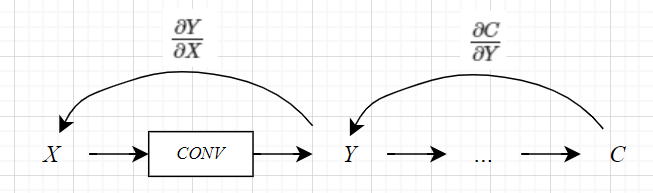

The chane rule states that,

\begin{align}
  \frac{\partial C }{\partial x_{i,j}}  = \sum_{l,k}{\frac{\partial C}{\partial y_{l,k}} \cdot  \frac{\partial  y_{l,k}}{\partial x_{i,j}}}
      \\
  \frac{\partial C }{\partial k_{i}}  = \sum_{l,k}{\frac{\partial C}{\partial y_{l,k}} \cdot  \frac{\partial  y_{l,k}}{\partial k_{i}}}
\end{align}


Since the convulation is a linear operation, and each $y_{l,k}$ is a liniar combination of $k_{m}$ and  $x_{i,j}$ we get:

\begin{align*}
   \frac{\partial C}{\partial x_{1,j}} = \frac{\partial C}{\partial y_{1,j}}\cdot k_{1}
   \quad  \textrm{for }\quad j=1,2,3 \quad
 \\
  \frac{\partial C}{\partial x_{2,j}} =
        \frac{\partial C}{\partial y_{1,j}}\cdot k_{2}  +
        \frac{\partial C}{\partial y_{2,j}}\cdot k_{1}
  \quad  \textrm{for }\quad j=1,2,3 \quad
 \\
  \frac{\partial C}{\partial x_{3,j}} = \frac{\partial C}{\partial y_{2,j}}\cdot k_{2}
  \quad  \textrm{for }\quad j=1,2,3 \quad  
\end{align*}


and ,

\begin{align*}
    \frac{\partial C }{\partial k_{1}} =
        \sum_{j=1}^{3}{\frac{\partial C}{\partial y_{1,j}} \cdot x_{1,j}}
        +
        \sum_{j=1}^{3}{\frac{\partial C}{\partial y_{2,j}} \cdot x_{2,j}}
\end{align*}

\begin{align*}
    \frac{\partial C }{\partial k_{2}} =
        \sum_{j=1}^{3}{\frac{\partial C}{\partial y_{1,j}} \cdot x_{2,j}}
        +
        \sum_{j=1}^{3}{\frac{\partial C}{\partial y_{2,j}} \cdot x_{3,j}}
\end{align*}



##**3. Transfer Learning**

Transfer Learning with CIFAR-10:

*  **Dataset Preparation:** Use the CIFAR-10 dataset with PyTorch.
Model Adaptation: Load a pre-trained ResNet model and replace its classification head to suit CIFAR-10.
*   **Training:** Fine-tune only the new classification head while keeping the rest of the model fixed.
*   **Evaluation:** Assess the accuracy of your model and find the top misclassified examples    







####**Step A: Creating a Dataset Object**

Setting num_workers=2 means that two subprocesses will be used to load the data. This can speed up data loading by parallelizing the I/O operations, especially when working with large datasets

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Values for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 as required by ResNet
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean, std)  # Normalize with mean and std of ImageNet
])

# Create CIFAR-10 dataset objects
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 57248382.10it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data

Files already downloaded and verified


####**Step B: Reading About the Dataset**

Information about the dataset can be found here: [CIFAR-10 webpage](https://www.cs.toronto.edu/~kriz/cifar.html).

The CIFAR-10 dataset is a widely-used dataset in the field of machine learning and computer vision. It consists of 60,000 color images in 10 different classes, with 6,000 images per class. The images are 32x32 pixels in size. The dataset is divided into 50,000 training images and 10,000 testing images.
There are 10 classes in the CIFAR-10 dataset. Each class contains images of various objects belonging to that category, captured in different poses, lighting conditions, and backgrounds, making it a challenging dataset for image classification tasks.

Here are the 10 classes in the CIFAR-10 dataset: Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.



####**Step C: Drawing Sample Images from Each Class**
The code collects and displays a grid of images from the CIFAR-10 dataset using the pyplot.imshow function.

 It allows specifying

*  the number of images per class to be displayed in the grid.
*  the mean and standard deviation for unnormalizing the images.

The grid layout shows each class in a separate row with the class name labeled on the left side, and the images are unnormalized and displayed with their original colors.

Note that the input of the pyplot.imshow function should be in the format (M, N, C), where the first two dimensions (M, N) define the rows and columns of the image, and the third dimension (C) is the color channel.



I get the code from chat GPT. Although, I've changed it to be more flexible and functional.

In [ ]:
num_images_per_class = 10
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

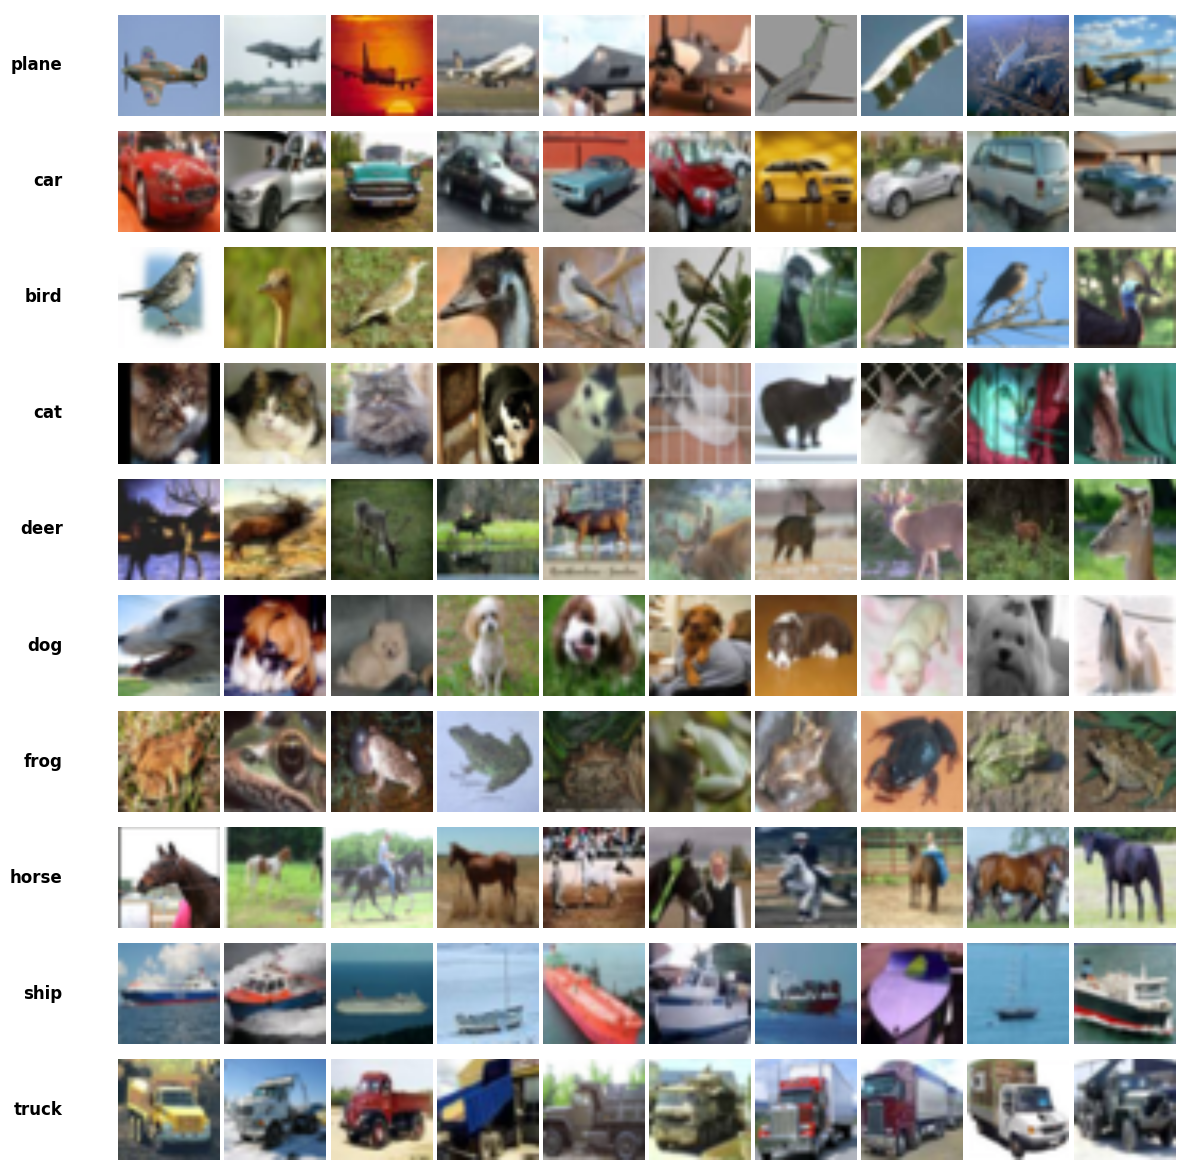

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

# Class names for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to collect images
def collect_images(dataset, num_images_per_class):
    '''
    Collects a specified number of images per class from the dataset.

    Args:
    dataset: The dataset to collect images from.
    num_images_per_class: The number of images to collect for each class.

    Returns:
    sorted_images: List of collected images, sorted by class.
    sorted_labels: List of corresponding labels, sorted by class.
    '''
    images = []
    labels = []
    class_counts = {class_name: 0 for class_name in classes}
    dataiter = iter(DataLoader(dataset, batch_size=1, shuffle=True))

    while sum(class_counts.values()) < num_images_per_class * 10:
        img, label = next(dataiter)
        class_name = classes[label.item()]
        if class_counts[class_name] < num_images_per_class:
            images.append(img.squeeze(0))  # Remove the batch dimension
            labels.append(label.item())
            class_counts[class_name] += 1

    # Sort images and labels by class
    sorted_images = []
    sorted_labels = []
    for class_idx in range(10):
        class_images = [img for img, lbl in zip(images, labels) if lbl == class_idx]
        sorted_images.extend(class_images)
        sorted_labels.extend([class_idx] * num_images_per_class)

    return sorted_images, sorted_labels

# Function to unnormalize the images
def unnormalize(img, mean, std):
    '''
    Unnormalizes the given image using the specified mean and standard deviation.

    Args:
    img: The image to unnormalize.
    mean: The mean used for normalization.
    std: The standard deviation used for normalization.

    Returns:
    img: The unnormalized image.
    '''
    mean = mean.numpy()
    std = std.numpy()
    img = img.numpy().transpose((1, 2, 0))  # Convert to numpy and transpose to HWC
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    return img

# Function to show a grid of images
def imshow_grid(images, labels, num_images_per_class, mean, std):
    '''
    Displays a grid of images with their corresponding class labels.

    Args:
    images: The list of images to display.
    labels: The list of corresponding labels.
    num_images_per_class: The number of images per class.
    mean: The mean used for normalization.
    std: The standard deviation used for normalization.
    '''
    fig, axes = plt.subplots(nrows=10, ncols=num_images_per_class + 1, figsize=(15, 15))
    for i in range(10):
        for j in range(num_images_per_class):
            ax = axes[i, j + 1]  # Shift image columns to the right
            img = unnormalize(images[i * num_images_per_class + j], mean, std)  # Unnormalize the image
            ax.imshow(img)  # Show the image
            ax.axis('off')

        # Set the label on the leftmost column of each row
        axes[i, 0].text(0.5, 0.5, classes[labels[i * num_images_per_class]], rotation=0, ha='right', va='center', fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')  # Hide the axis for the label cell

    plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Adjust spacing to improve layout
    plt.show()


# Main code
sorted_images, sorted_labels = collect_images(train_dataset, num_images_per_class)
imshow_grid(sorted_images, sorted_labels, num_images_per_class, mean, std)


####**Step D: Loading Pretrained ResNet**

We will use the pretrained resnet18 model from ImageNet.

In [ ]:
import torchvision.models as models

# Load a pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

  warnings.warn(

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth

100%|██████████| 44.7M/44.7M [00:00<00:00, 57.0MB/s]


print the model's architecture

In [ ]:
print(resnet18)

ResNet(

  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  (relu): ReLU(inplace=True)

  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  (layer1): Sequential(

    (0): BasicBlock(

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (relu): ReLU(inplace=True)

      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    )

    (1): BasicBlock(

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

      (relu): ReLU(

####**Step E: Replacing the Classification Head**

We need to modify the classification head of the ResNet18 model to suit the CIFAR-10 dataset.

In [ ]:
import torch.nn as nn

# Replace the fully connected layer to match CIFAR-10 classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)  # CIFAR-10 has 10 classes

Calculate the number of parameters in the model

In [ ]:
# code is written by chat GPT

# Function to calculate number of parameters in a model or layer
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print total number of parameters in the entire model
total_params = count_parameters(resnet18)
print(f"Total number of parameters in the model: {total_params}")

# Print number of parameters in each layer
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name} \t Number of parameters: {param.numel()}")

# Summarize parameters in the classifier (fully connected layer)
classifier_params = count_parameters(resnet18.fc)
print(f"Number of parameters in the classifier (fully connected layer): {classifier_params}")

Total number of parameters in the model: 11689512

Layer: conv1.weight 	 Number of parameters: 9408

Layer: bn1.weight 	 Number of parameters: 64

Layer: bn1.bias 	 Number of parameters: 64

Layer: layer1.0.conv1.weight 	 Number of parameters: 36864

Layer: layer1.0.bn1.weight 	 Number of parameters: 64

Layer: layer1.0.bn1.bias 	 Number of parameters: 64

Layer: layer1.0.conv2.weight 	 Number of parameters: 36864

Layer: layer1.0.bn2.weight 	 Number of parameters: 64

Layer: layer1.0.bn2.bias 	 Number of parameters: 64

Layer: layer1.1.conv1.weight 	 Number of parameters: 36864

Layer: layer1.1.bn1.weight 	 Number of parameters: 64

Layer: layer1.1.bn1.bias 	 Number of parameters: 64

Layer: layer1.1.conv2.weight 	 Number of parameters: 36864

Layer: layer1.1.bn2.weight 	 Number of parameters: 64

Layer: layer1.1.bn2.bias 	 Number of parameters: 64

Layer: layer2.0.conv1.weight 	 Number of parameters: 73728

Layer: layer2.0.bn1.weight 	 Number of parameters: 128

Layer: layer2.0.bn1.b

####**Step F: Training the New Classification Head**

We'll train only the new classification head while freezing the rest of the network.

**Create Train Test and Validation Dataloaders**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Values for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 as required by ResNet
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean, std)  # Normalize with mean and std of ImageNet
])

# Create CIFAR-10 dataset objects
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the train_dataset into training and validation sets
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Verify the data loader sizes
print(f"Train DataLoader size: {len(train_loader.dataset)}")
print(f"Validation DataLoader size: {len(val_loader.dataset)}")
print(f"Test DataLoader size: {len(test_loader.dataset)}")


100%|██████████| 170498071/170498071 [00:04<00:00, 41251254.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data

Files already downloaded and verified

Train DataLoader size: 40000

Validation DataLoader size: 10000

Test DataLoader size: 10000


**Evaluate the Model on the Test or Validation Dataset Functon**

In [ ]:
def evaluate_model(model, criterion, device , dataloaders, data_name):
    '''
    Evaluates the performance of a given model on a specified dataset.

    Args:
    model: The model to be evaluated.
    criterion: The loss function to be used for evaluation.
    device: The device (CPU or GPU) to run the evaluation on.
    dataloaders: A dictionary containing DataLoader objects for the datasets.
    data_name: The key to the specific DataLoader in the dataloaders dictionary to use for evaluation.

    Returns:
    running_loss: The total loss accumulated over the dataset.
    correct: The number of correct predictions made by the model.
    total: The total number of labels processed.
    '''
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloaders[data_name]:
            images, labels = images.to(device), labels.to(device) # Move to device
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # Get the predicted class by selecting the class with the highest score
            total += labels.size(0)  # Update the total number of labels processed
            correct += (predicted == labels).sum().item() # Update the count of correct predictions
    return running_loss , correct , total

**Training Function**

In [ ]:
# Training function
def train_model(dataloaders, model, criterion, optimizer, device, num_epochs=25):
    '''
    Trains a given model using the specified dataloaders, criterion, optimizer, and device.

    Args:
    dataloaders: A dictionary containing DataLoader objects for training and validation datasets.
    model: The model to be trained.
    criterion: The loss function to be used for training.
    optimizer: The optimizer to use for model parameter updates.
    device: The device (CPU or GPU) to run the training on.
    num_epochs: The number of epochs to train the model (default is 25).

    Returns:
    train_accuracies: List of training accuracies for each epoch.
    val_accuracies: List of validation accuracies for each epoch.
    train_losses: List of training losses for each epoch.
    val_losses: List of validation losses for each epoch.
    '''
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0    # Initialize running loss
        correct_train = 0     # Initialize count of correct predictions
        total_train = 0       # Initialize count of total samples

        # Loop over batches in the training data
        for images, labels in dataloaders['train']:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass: compute the model output for the input images
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()   # Backpropagate the loss
            optimizer.step()  # Update the model parameters

            running_train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total_train += labels.size(0)     # Update total sample count
            correct_train += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        train_losses.append(running_train_loss / len(dataloaders['train']))
        train_accuracies.append(100 * correct_train / total_train)


        # Validation
        loss_val , correct_val, total_val  = evaluate_model(model, criterion, device , dataloaders, data_name='val')

        # Calculate average validation loss and accuracy
        val_losses.append(loss_val / len(dataloaders['val']))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    print("Finished Training")
    return train_accuracies, val_accuracies, train_losses, val_losses

**Plot  progress Function**

In [ ]:
import matplotlib.pyplot as plt

def plots(train_loss_list, val_loss_list, train_acc_list , val_acc_list):
      '''
      Plots the training and validation loss and accuracy curves.

      Args:
      train_loss_list: List of training losses for each epoch.
      val_loss_list: List of validation losses for each epoch.
      train_acc_list: List of training accuracies for each epoch.
      val_acc_list: List of validation accuracies for each epoch.
      '''
      plt.figure(figsize=(10, 5))

      num_epochs= len(train_loss_list)

      # Plot loss curves
      plt.subplot(1, 2, 1)
      plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
      plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)
      # plt.show()

      # Plot accuracy curves
      plt.subplot(1, 2, 2)
      plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
      plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy (%)')
      plt.legend()
      plt.grid(True)

      plt.show()


**Training the model**

In [ ]:
# Freeze all the network parameters
for param in resnet18.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the new fully connected layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)

# Set devise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device =" , device)

# Move the model to GPU
resnet18.to(device)

import time
start = time.time() # Record the start time

# Train the model
train_accuracies1, val_accuracies1, train_losses1, val_losses1 = \
   train_model(dataloaders, resnet18, criterion, optimizer, device, num_epochs=12)

end  = time.time()  # Record the end time
# print(f'Training process took {end - start:.2f} seconds')

elapsed_time = end - start # Calculate the training time in minutes and seconds
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f'Training process took {int(minutes)} minutes and {seconds:.2f} seconds')

device = True

Epoch [1/12], Train Loss: 1.6345, Train Accuracy: 51.09%, Val Loss: 1.1750, Val Accuracy: 68.84%

Epoch [2/12], Train Loss: 1.0276, Train Accuracy: 71.76%, Val Loss: 0.9009, Val Accuracy: 74.16%

Epoch [3/12], Train Loss: 0.8516, Train Accuracy: 74.76%, Val Loss: 0.7912, Val Accuracy: 75.77%

Epoch [4/12], Train Loss: 0.7680, Train Accuracy: 76.07%, Val Loss: 0.7346, Val Accuracy: 76.90%

Epoch [5/12], Train Loss: 0.7208, Train Accuracy: 77.10%, Val Loss: 0.6968, Val Accuracy: 77.38%

Epoch [6/12], Train Loss: 0.6898, Train Accuracy: 77.73%, Val Loss: 0.6736, Val Accuracy: 77.67%

Epoch [7/12], Train Loss: 0.6662, Train Accuracy: 78.22%, Val Loss: 0.6521, Val Accuracy: 78.46%

Epoch [8/12], Train Loss: 0.6497, Train Accuracy: 78.60%, Val Loss: 0.6369, Val Accuracy: 78.44%

Epoch [9/12], Train Loss: 0.6338, Train Accuracy: 78.89%, Val Loss: 0.6302, Val Accuracy: 78.47%

Epoch [10/12], Train Loss: 0.6257, Train Accuracy: 79.17%, Val Loss: 0.6202, Val Accuracy: 78.82%

Epoc

**Plotting the training progress**

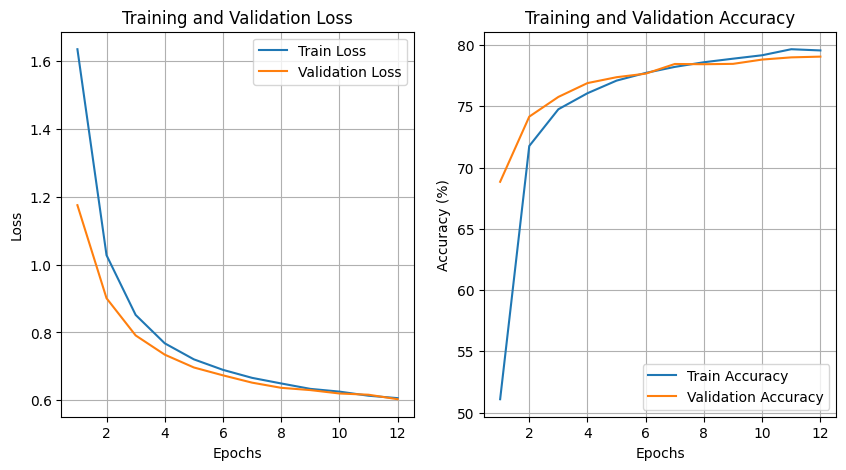

In [ ]:
plots(train_losses1, val_losses1, train_accuracies1 , val_accuracies1)

####**Step G: Evaluating Model Accuracy on Test Set**

We'll evaluate the accuracy of the trained model on the test set.

In [ ]:
import time
start = time.time() # Record the start time

# Evaluate the model
loss_test1 , correct_test1, total_test1  = \
    evaluate_model(resnet18, criterion, device , dataloaders, data_name='test')
print('Test Accuracy of the network on the test images: {} %'.format(100 * correct_test1 / total_test1))

end  = time.time()  # Record the end time
print(f'Training process took {end - start:.2f} seconds')

Test Accuracy of the network on the test images: 79.7 %

Training process took 25.83 seconds


In [ ]:
# Move model back to CPU
# resnet18.to('cpu')

# # Save the model
# torch.save(resnet18.state_dict(), 'resnet18_cifar10.pth')
# print("Model saved to resnet18_cifar10.pth")
print(device)

cuda:0


**Description**

1. **Data Preparation**:
  * Resizes images to 224x224 and normalizes them
  * Training DataLoader: 40,000 images
  * Validation DataLoader: 10,000 images
  * Test DataLoader: 10,000 images

2. **Model Architecture:**

  * ResNet1 (transform learning)
  * The original fully connected layer was replaced with a new fully connected layer that has 10 output units.
  * All parameters of the ResNet-18 backbone (except the new fully connected layer) are frozen, meaning they will not be updated during training.
  * Total number of parameters in the model:  11,689,512
  * Number of parameters in the classifier (fully connected layer): 513,000

3. **Training Configuration:**

  * Model trained for 12 epochs.
  * Uses Cross Entropy Loss and Adam optimizer with a learning rate of 0.0001.
  
  (I tested SGD with a 0.001 learning rate,  ADAM with a 0.001 learning rate.Performance was less good)

**Results**

It can be seen that at the end of the training the performance of the model on the training data was: LOSS of 0.6065 and an accuracy level of 79.56%, while on the validation it was 0.6033 and 79.06%.

The performance of the model on the test was 79.7% and overall the model meets the requirements.

The training process took about 30 minutes.

It is evident that the learning of the graphs of the LOSS and the level of accuracy progressed well without evidence of overfitting.
At the same time, the learning started from a high threshold and was slower as expected, compared to what you see in the models in which we train all the parameters.

####**Step H: Finding the Top-10 Misclassified Samplest**

We'll find the top-10 misclassified samples with the highest confidence.

IT is useful for identifying and analyzing the most confident misclassifications made by the model, which can provide insights into the model's weaknesses and areas for improvement.







We use: The `heapq` module in Python provides an implementation of the heap queue algorithm, also known as the priority queue algorithm. Heaps are binary trees for which every parent node has a value less than or equal to any of its children. The `heapq` module provides functions to perform operations on heaps, such as inserting and extracting the smallest element, which makes it suitable for maintaining a list of the largest or smallest elements in a collection.

The explanation of the snippet:
```
if len(errors) > num_errors:  # Keep only the top N errors
    errors = heapq.nlargest(num_errors, errors, key=lambda x: x[0])
```

1. Condition Check:

  * if len(errors) > num_errors:
  * This checks if the current number of errors in the errors list is greater than the allowed number (num_errors). If the length of the errors list exceeds num_errors, it proceeds to the next step.

2. Keep Top N Errors: errors = heapq.nlargest(num_errors, errors, key=lambda x: x[0])

  * heapq.nlargest: This function from the heapq module is used to retrieve the largest num_errors elements from the errors list.

  * Parameters:

    * num_errors: The number of top errors to keep.
    * errors: The list of errors to filter.
    * key=lambda x: x[0]: This specifies that the errors should be compared based on the first element of each error tuple (x[0]). The lambda function is used as a key to determine how the elements in errors are compared.

  * Result: The heapq.nlargest function returns a new list containing the top num_errors largest elements based on the specified key, which replaces the original errors list.

Code is written by chat GPT

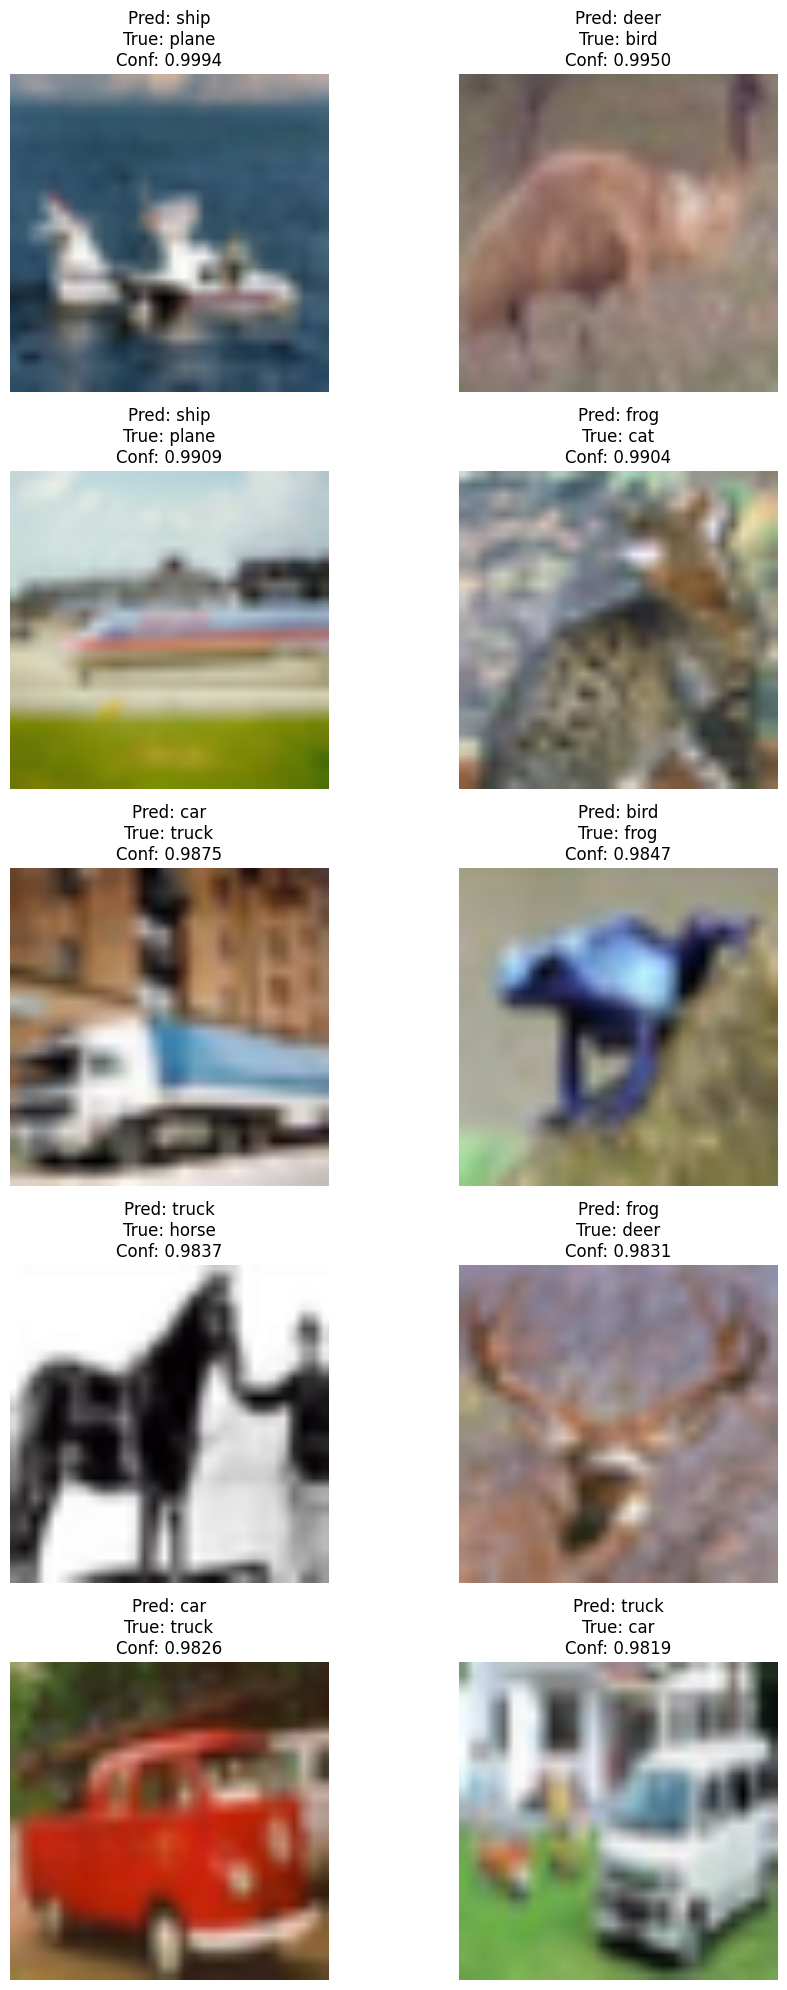

In [ ]:
import torch
import torch.nn.functional as F
import heapq
import matplotlib.pyplot as plt
import numpy as np

# Values for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Function to unnormalize the images
def unnormalize(img, mean, std):
    '''
    Unnormalize an image tensor using the provided mean and std values.

    Args:
    img: The image tensor to be unnormalized.
    mean: The mean values used for normalization.
    std: The standard deviation values used for normalization.

    Returns:
    Unnormalized image as a numpy array.
    '''
    mean = mean.numpy()
    std = std.numpy()
    img = img.numpy().transpose((1, 2, 0))  # Convert to numpy and transpose to HWC
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    return img

# Function to show an image
def imshow(img, ax):
    '''
    Display an image using Matplotlib.

    Args:
    img: The image tensor to be displayed.
    ax: The Matplotlib axis to display the image on.
    '''
    img = unnormalize(img, mean, std)  # Unnormalize the image
    ax.imshow(img)  # Display the image
    ax.axis('off')  # Hide the axes

# Function to find the top misclassified images with the highest confidence scores
def find_top_errors(model, dataloaders, num_errors=10):
    '''
    Find the top misclassified images with the highest confidence scores.

    Args:
    model: The trained model to evaluate.
    dataloaders: The dataloaders dictionary containing the validation dataloader.
    num_errors: The number of top errors to return.

    Returns:
    A list of tuples containing (confidence, image, predicted, true_label).
    '''
    model.eval()  # Set the model to evaluation mode
    errors = []  # List to store errors
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloaders['test']:  # Loop through test data
            images, labels = images.to(device), labels.to(device)  # Move images and labels to device
            outputs = model(images)  # Get model outputs
            probabilities = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities
            _, predicted = torch.max(outputs, 1)  # Get predicted classes
            for i in range(len(labels)):  # Loop through each image in the batch
                if predicted[i] != labels[i]:  # Check if the prediction is incorrect
                    confidence = probabilities[i][predicted[i]].item()  # Get confidence score of the incorrect prediction
                    errors.append((confidence, images[i].cpu(), predicted[i], labels[i]))  # Append the error to the list
                    if len(errors) > num_errors:  # Keep only the top N errors
                        errors = heapq.nlargest(num_errors, errors, key=lambda x: x[0])
    return errors

# Find top errors
top_errors = find_top_errors(resnet18, dataloaders)

# Class names for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Plot the top errors in a grid
fig, axes = plt.subplots(5, 2, figsize=(10, 20))  # Create a grid of subplots

for i, (confidence, image, predicted, true_label) in enumerate(top_errors):
    ax = axes[i // 2, i % 2]  # Select the subplot
    imshow(image, ax)  # Display the image
    ax.set_title(f'Pred: {classes[predicted]}\nTrue: {classes[true_label]}\nConf: {confidence:.4f}')  # Set the title

plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot


####**Step I: Creating a New Costum Model with Residual Blocks**

We'll create a new model consisting of three residual blocks, adaptive average pooling, and a classification head.


**CIFAR10ResNet** is a small ResNet-like architecture adapted for CIFAR-10 classification. It contains,

* three sequential residual blocks (ResBlockDownSamp) with downsampling to progressively reduce spatial dimensions while increasing the number of channels
* an adaptive average pooling layer
* classifier head for the final classification using fully connected layers with batch normalization, dropout, and ReLU activations for regularization and non-linearity

This model is a small ResNet-like architecture adapted for CIFAR-10 classification. It includes residual blocks with downsampling to progressively reduce spatial dimensions while increasing the number of channels. The final classification is done using fully connected layers with batch normalization, dropout, and ReLU activations for regularization and non-linearity.


you can follow the structure outlined below,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


**Model Definition**

Define the ResBlockDownSamp and CIFAR10ResNet classes:


I took from the textbook (page 147) the code fot the ResBlockDownSamp.
I ask chat GPT to build a model with instruction that i gave it, and then played with the parameters and layers to get a model which yields good results.

In [ ]:
import torch
import torch.nn as nn

class ResBlockDownSamp(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels * 2
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same", bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsampX = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False)
        self.bnX   = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        y1 = self.conv1(x)    # convolutional layer with downsampling. No bias (bias is not needed when followed by batch normalization)
        y1 = self.bn1(y1)     # Normalizes the channels of each feature map independently
        y1 = self.relu(y1)    # ReLU Activation to introduce non-linearity
        y1 = self.conv2(y1)   # No bias (bias is not needed when followed by batch normalization)
        y1 = self.bn2(y1)     # Normalizes the channels of each feature map independently
        x = self.downsampX(x) # Downsampled input using downsampX to match dimensions of y1
        x = self.bnX(x)       # Normalizes the channels of each feature map independently
        y2 = y1 + x           # skip connection
        y = self.relu(y2)     # Final output after applying ReLU to y2.
        return y

class CIFAR10ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10ResNet, self).__init__()
        self.initial_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # Initial convolutional layer
        self.bn = nn.BatchNorm2d(32)         #  Normalizes the channels of each feature map independently
        self.relu = nn.ReLU()                # ReLU activation function.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.layer1 = ResBlockDownSamp(32)   # First residual block, downsampling from 32 to 64 channels
        self.layer2 = ResBlockDownSamp(64)   # Second residual block, downsampling from 64 to 128 channels
        self.layer3 = ResBlockDownSamp(128)  # Third residual block, downsampling from 128 to 256 channels
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # Adaptive average pooling layer to reduce the spatial dimensions to 1x1
        self.fc = nn.Sequential(
            nn.Linear(256, 128), # First linear layer with batch normalization, dropout, and ReLU
            nn.BatchNorm1d(128), # Normalizes across the features.
            nn.Dropout(p=0.5),   # Dropout layer with 50% dropout rate.
            nn.ReLU(),           # ReLU activation function.
            nn.Linear(128, 128), # Second linear layer with batch normalization, dropout, and ReLU
            nn.BatchNorm1d(128), # Normalizes across the features.
            nn.Dropout(p=0.5),   # Dropout layer with 50% dropout rate.
            nn.ReLU(),           # ReLU activation function.
            nn.Linear(128, num_classes) # Final linear layer for classification.
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)  # Apply max pooling after the initial convolution and ReLU
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)      # Spatial dimensions reduced to 1x1 using avg_pool.
        x = x.view(x.size(0), -1) # Flattened to a 1D tensor
        x = self.fc(x)            # Passed through the fully connected layers (fc)
        return x


**Count the number of parameters in each layer**

In [ ]:
model = CIFAR10ResNet()

# print(model)

def print_layer_params(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_params = param.numel()
            total_params += layer_params
            print(f'Layer: {name}, Parameters: {layer_params}')
    print(f'Total number of trainable parameters in the model: {total_params}')

print_layer_params(model)

Layer: initial_conv.weight, Parameters: 864
Layer: bn.weight, Parameters: 32
Layer: bn.bias, Parameters: 32
Layer: layer1.conv1.weight, Parameters: 18432
Layer: layer1.bn1.weight, Parameters: 64
Layer: layer1.bn1.bias, Parameters: 64
Layer: layer1.conv2.weight, Parameters: 36864
Layer: layer1.bn2.weight, Parameters: 64
Layer: layer1.bn2.bias, Parameters: 64
Layer: layer1.downsampX.weight, Parameters: 2048
Layer: layer1.bnX.weight, Parameters: 64
Layer: layer1.bnX.bias, Parameters: 64
Layer: layer2.conv1.weight, Parameters: 73728
Layer: layer2.bn1.weight, Parameters: 128
Layer: layer2.bn1.bias, Parameters: 128
Layer: layer2.conv2.weight, Parameters: 147456
Layer: layer2.bn2.weight, Parameters: 128
Layer: layer2.bn2.bias, Parameters: 128
Layer: layer2.downsampX.weight, Parameters: 8192
Layer: layer2.bnX.weight, Parameters: 128
Layer: layer2.bnX.bias, Parameters: 128
Layer: layer3.conv1.weight, Parameters: 294912
Layer: layer3.bn1.weight, Parameters: 256
Layer: layer3.bn1.bias, Parameters

**Prepare the CIFAR-10 dataset**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Values for normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to 224x224 as required by ResNet
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean, std)  # Normalize with mean and std of ImageNet
])

# Create CIFAR-10 dataset objects
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the train_dataset into training and validation sets
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

# Verify the data loader sizes
print(f"Train DataLoader size: {len(train_loader.dataset)}")
print(f"Validation DataLoader size: {len(val_loader.dataset)}")
print(f"Test DataLoader size: {len(test_loader.dataset)}")


100%|██████████| 170498071/170498071 [00:18<00:00, 8981992.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train DataLoader size: 40000
Validation DataLoader size: 10000
Test DataLoader size: 10000


**Evaluate the Model on the Test or Validation Dataset Functon**

In [ ]:
def evaluate_model(model, criterion, device , dataloaders, data_name):
    model.eval()  # Set model to evaluate mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloaders[data_name]:
            images, labels = images.to(device), labels.to(device) # Move to device
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1) # Get the predicted class by selecting the class with the highest score
            total += labels.size(0)  # Update the total number of labels processed
            correct += (predicted == labels).sum().item() # Update the count of correct predictions
    return running_loss , correct , total

**Training Function**

In [ ]:
# Training function
def train_model(dataloaders, model, criterion, optimizer, device, num_epochs=25):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Loop over the number of epochs
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0    # Initialize running loss
        correct_train = 0     # Initialize count of correct predictions
        total_train = 0       # Initialize count of total samples

        # Loop over batches in the training data
        for images, labels in dataloaders['train']:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass: compute the model output for the input images
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()   # Backpropagate the loss
            optimizer.step()  # Update the model parameters

            running_train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total_train += labels.size(0)     # Update total sample count
            correct_train += (predicted == labels).sum().item()

        # Calculate average loss and accuracy for the epoch
        train_losses.append(running_train_loss / len(dataloaders['train']))
        train_accuracies.append(100 * correct_train / total_train)


        # Validation
        loss_val , correct_val, total_val  = evaluate_model(model, criterion, device , dataloaders, data_name='val')

        # Calculate average validation loss and accuracy
        val_losses.append(loss_val / len(dataloaders['val']))
        val_accuracies.append(100 * correct_val / total_val)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    print("Finished Training")
    return train_accuracies, val_accuracies, train_losses, val_losses

**Plot  progress Function**

In [ ]:
import matplotlib.pyplot as plt

def plots(train_loss_list, val_loss_list, train_acc_list , val_acc_list):
      plt.figure(figsize=(10, 5))

      num_epochs= len(train_loss_list)

      # Plot loss curves
      plt.subplot(1, 2, 1)
      plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
      plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.grid(True)
      # plt.show()

      # Plot accuracy curves
      plt.subplot(1, 2, 2)
      plt.plot(range(1, num_epochs + 1), train_acc_list, label='Train Accuracy')
      plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy (%)')
      plt.legend()
      plt.grid(True)

      plt.show()


**Set up the training process**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =" , device)
model = CIFAR10ResNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = cuda


**Training loop**

In [ ]:
import time
start = time.time() # Record the start time

# Train the model
train_accuracies1, val_accuracies1, train_losses1, val_losses1 = \
   train_model(dataloaders, model, criterion, optimizer, device, num_epochs=15)

end  = time.time()  # Record the end time

elapsed_time = end - start  # Calculate the training time in minutes and seconds
minutes = elapsed_time // 60
seconds = elapsed_time % 60

print(f'Training process took {int(minutes)} minutes and {seconds:.2f} seconds')

Epoch [1/15], Train Loss: 1.8240, Train Accuracy: 31.06%, Val Loss: 1.5535, Val Accuracy: 42.36%
Epoch [2/15], Train Loss: 1.4159, Train Accuracy: 47.94%, Val Loss: 1.3767, Val Accuracy: 49.96%
Epoch [3/15], Train Loss: 1.2000, Train Accuracy: 57.01%, Val Loss: 1.0960, Val Accuracy: 60.14%
Epoch [4/15], Train Loss: 1.0754, Train Accuracy: 61.80%, Val Loss: 1.1383, Val Accuracy: 60.08%
Epoch [5/15], Train Loss: 0.9734, Train Accuracy: 65.39%, Val Loss: 0.9269, Val Accuracy: 67.01%
Epoch [6/15], Train Loss: 0.8918, Train Accuracy: 68.84%, Val Loss: 0.8680, Val Accuracy: 68.90%
Epoch [7/15], Train Loss: 0.8253, Train Accuracy: 71.42%, Val Loss: 0.8553, Val Accuracy: 70.31%
Epoch [8/15], Train Loss: 0.7553, Train Accuracy: 73.94%, Val Loss: 0.8137, Val Accuracy: 71.91%
Epoch [9/15], Train Loss: 0.6897, Train Accuracy: 76.47%, Val Loss: 0.6796, Val Accuracy: 76.27%
Epoch [10/15], Train Loss: 0.6339, Train Accuracy: 78.52%, Val Loss: 0.6582, Val Accuracy: 77.33%
Epoch [11/15], Train Loss: 0.

**Plotting the training progress**


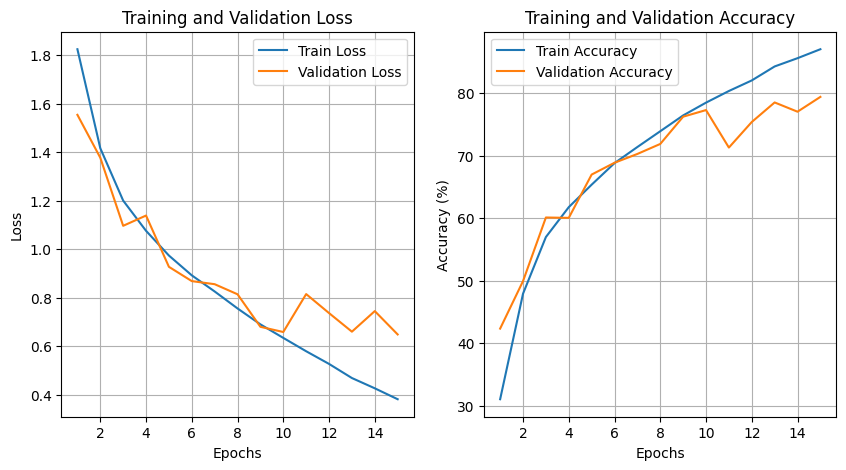

In [ ]:
plots(train_losses1, val_losses1, train_accuracies1 , val_accuracies1)

**Evaluating Model Accuracy on Test Set**

In [ ]:
import time
start = time.time() # Record the start time

# Evaluate the model
loss_test1 , correct_test1, total_test1  = \
    evaluate_model(model, criterion, device , dataloaders, data_name='test')
print('Test Accuracy of the network on the test images: {} %'.format(100 * correct_test1 / total_test1))

end  = time.time()  # Record the end time
print(f'Training process took {end - start:.2f} seconds')

Test Accuracy of the network on the test images: 79.54 %
Training process took 25.46 seconds


**Summary and conclusions**

**Description**

1. **Data Preparation**:
  * Resizes images to 224x224 and normalizes them
  * Training DataLoader: 40,000 images
  * Validation DataLoader: 10,000 images
  * Test DataLoader: 10,000 images

2. **Model Architecture:**

  * Custom ResNet with three residual blocks (ResBlockDownSamp).
  * Initial convolutional layer, three residual blocks, adaptive average pooling, and a fully connected classifier with dropout for regularization.
  * Total number of parameters in the model:  1,259,050

3. **Training Configuration:**

  * Model trained for 15 epochs.
  * Uses Cross Entropy Loss and Adam optimizer with a learning rate of 0.001.

  * I tried different configurations so that the number of parameters would be up to 1.5 million so that the running time would be reasonable in relation to performance. When I saw that there was overfitting, I added a dropout layer to the calcifer and it significantly improved the performance.

**Results:**

It can be seen that at the end of the training the performance of the model on the training data was: LOSS of 0.3811 and an accuracy level of 87.07%, while on the validation it was 0.6481 and 78.44%.

The performance of the model on the test was 79.54% and overall the model meets the requirements.

The training process took about 41 minutes.

It is evident that the learning of the graphs of the LOSS and the level of accuracy progressed well without clear evidence of overfitting.


#### **Step J: Evaluating and Comparing Models**
We'll evaluate the accuracy of the new custom model CIFAR10ResNet and compare it with the original modified ResNet18 model.

Comparison ResNet18 vs CIFAR10ResNet:
* Pretrained parameters:  about 11,000,000 | None
* Trained parameters:  about 500,000 | about 1,200,000
* Accuracy on the test set: 79.7% | 79.54%
* Training time:  38 min | 27 min

The number of trained parameters in ResNet18 was less than half compared to the second model, and accordingly, the training time was shorter.

Training over 15 epochs yielded similar accuracy results.

The training process of ResNet18 showed smoother graphs than that of CIFAR10ResNet. This might be because CIFAR10ResNet has many more parameters, leading to greater variability during training. Additionally, the training of ResNet18 started from a high threshold with a slow learning rate, while the second model started from a low threshold and a higher learning rate, resulting in slightly less good results with a number of constraints similar to ResNet18.

In general, a custom model can be more flexible, for example, with data processing or the architecture of feature extraction layers, and sometimes it could be a better option to use.

However, given the current results, I would prefer to use ResNet18 because its performance is better and more stable, and the computation is faster.
